In [87]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import platform
import plotly.graph_objects as go
from matplotlib import font_manager,rc

get_ipython().run_line_magic('matplotlib','inline')
# %matplotlib inline

path = 'C:/Windows/Fonts/malgun.ttf'

if platform.system() == 'Darwin':
    rc('font',family='Arial Unicode MS')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font',family=font_name)
else:
    print('Unknown system, sorry~')

from sklearn.decomposition import PCA

from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [88]:
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# 한국어 설정
from matplotlib import font_manager, rc
rc("font",family ='Malgun Gothic')
%matplotlib inline

In [89]:
# 엑셀 파일을 읽어옵니다.
df = pd.read_excel('../data/file/imdb_final_6.xlsx', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 905 entries, 0 to 904
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   korean_title        905 non-null    object 
 1   english_title       905 non-null    object 
 2   year                905 non-null    int64  
 3   total_season_num    905 non-null    int64  
 4   runtime             905 non-null    int64  
 5   genre               905 non-null    object 
 6   age_rating          905 non-null    object 
 7   production_country  905 non-null    object 
 8   total_count         905 non-null    int64  
 9   total_rate          905 non-null    float64
 10  watchlist           905 non-null    int64  
 11  popularity          905 non-null    int64  
 12  user_review         905 non-null    int64  
 13  critic_review       905 non-null    int64  
 14  production          821 non-null    object 
 15  distributor         897 non-null    object 
 16  season_1     

In [90]:
df = df[df['total_season_num']>=2]

In [91]:
# 문자열을 리스트로 변환하는 함수
def parseStringToList(string):
    if pd.isna(string):  # NaN 값인 경우 빈 리스트 반환
        return None
    # 문자열에서 각 요소를 구분하는 쉼표로 분할
    elements = string.split(', ')
    # 각 요소에서 양쪽의 작은따옴표 제거
    elements = [element.strip("['").strip("']") for element in elements]
    return elements
# 'production','distributor' 컬럼의 값을 변환
df['production'] = df['production'].apply(parseStringToList)
df['distributor'] = df['distributor'].apply(parseStringToList)

In [92]:
import ast

# 문자열을 딕셔너리로 변환하는 함수
def preprocess_data(data_str):
    try:
        data_dict = ast.literal_eval(data_str)
        if not data_dict:  # 빈 딕셔너리인 경우
            return None
        else:
            return data_dict
    except (ValueError, SyntaxError):
        return None  # 오류 발생 시 None 반환
    
# # season_으로 시작하는 컬럼에 대해서만 변환 적용
# for column in df_im.columns:
#     if column.startswith('season_'):
#         df_im[column] = df_im[column].apply(preprocess_data)

df['season_1'] = df['season_1'].apply(preprocess_data)

In [93]:
# season_1에 대한 평균 계산
season_1 = df['season_1']

# 평균 rating 계산
avg_rating_season_1 = season_1.apply(
    lambda x: np.mean([ep[0] for ep in x.values()]) if x else None
)

# 평균 views 계산
avg_views_season_1 = season_1.apply(
    lambda x: np.mean([ep[1] for ep in x.values()]) if x else None
)

In [94]:
# df_im에 s1_avg_rating, s1_avg_views 컬럼 추가
df['s1_avg_rating'] = avg_rating_season_1
df['s1_avg_views'] = avg_views_season_1

In [95]:
# 시청 지속율(관심유지도) 계산 함수
def calculate_retention_rate(season_data):
    episode_views = [ep[1] for ep in season_data.values() if isinstance(ep, (list, tuple))]
    if len(episode_views) > 1:
        initial_viewers = episode_views[0]
        final_viewers = episode_views[-1]
        retention_rate = (final_viewers / initial_viewers) * 100
    else:
        retention_rate = 100  # If there's only one episode, retention is 100%
    return retention_rate

# 시즌 1의 시청 지속율 계산
df['s1_retention_rate'] = df['season_1'].apply(calculate_retention_rate)

In [96]:
# 'date_of_first' 컬럼 추가
df['date_of_first'] = [next(iter(data_dict.values()))[2] for data_dict in df['season_1']]
# 'date_of_second' 컬럼 추가
df['date_of_second'] = [list(data_dict.values())[1][2] if len(data_dict) > 1 else None for data_dict in df['season_1']]
# 'date_of_last' 컬럼 추가
df['date_of_last'] = [list(data_dict.values())[-1][2] for data_dict in df['season_1']]
# 'term' 컬럼 추가
df['term'] = df.apply(lambda row: 0 if row['date_of_last'] == row['date_of_first'] else (1 if row['date_of_first'] == row['date_of_second'] else 2), axis=1)

# 결과 확인
print(df[['season_1', 'date_of_first', 'date_of_second', 'date_of_last', 'term']])

                                                     season_1  \
Unnamed: 0                                                      
3           {'S1.E1': [7.9, 2500, 'Fri, Jun 4, 2021'], 'S1...   
4           {'S1.E1': [7.1, 1100, 'Fri, Dec 18, 2020'], 'S...   
6           {'S1.E1': [8.6, 4800, 'Mon, Jul 12, 2021'], 'S...   
7           {'S1.E1': [9.2, 30000, 'Tue, Oct 8, 2019'], 'S...   
8           {'S1.E1': [8.0, 770, 'Sun, Jan 8, 2012'], 'S1....   
...                                                       ...   
868         {'S1.E1': [7.6, 304, 'Fri, Aug 10, 2018'], 'S1...   
869         {'S1.E1': [6.7, 141, 'Fri, Mar 20, 2020'], 'S1...   
881         {'S1.E1': [6.5, 349, 'Fri, Sep 22, 2017'], 'S1...   
882         {'S1.E1': [7.0, 66, 'Sat, Nov 30, 2019'], 'S1....   
884         {'S1.E1': [7.0, 110, 'Fri, Feb 21, 2020'], 'S1...   

                date_of_first     date_of_second       date_of_last  term  
Unnamed: 0                                                                 
3 

In [97]:
# 이 컬럼은 여기서 사용하지 않을 예정이라 잠시 뺌
del df['date_of_first']
del df['date_of_second']
del df['date_of_last']

del df['season_1']

In [98]:
# 이 컬럼은 여기서 사용하지 않을 예정이라 잠시 뺌
del df['season_2']
del df['season_3']
del df['season_4']
del df['season_5']
del df['season_6']
del df['season_7']
del df['season_8']
del df['season_9']
del df['season_10']
del df['season_11']
del df['season_12']
del df['season_13']
del df['season_14']
del df['season_15']
del df['season_16']
del df['season_17']

In [99]:
# 이 컬럼은 여기서 사용하지 않을 예정이라 잠시 뺌
del df['year']  # 차라리 term을 넣기

del df['production']
del df['distributor']
del df['director']
del df['writer']
del df['actor']

In [100]:
# 드라마의 전반적인 인기
del df['total_season_num']
del df['total_count']
del df['total_rate']
del df['watchlist']
del df['popularity']

del df['user_review']
del df['critic_review']
del df['wins']
del df['nominations']

del df['imdb_title']
del df['imdb_url']

In [101]:
# 장르 인코딩 못함
del df['genre']

In [102]:
# production_country 컬럼의 데이터를 처리하는 함수 정의
def process_countries(countries):
    # 쉼표를 기준으로 분리하고 첫 번째 나라 선택
    countries_list = countries.split(',')
    first_country = countries_list[0].strip()
    return first_country

# apply 함수를 사용하여 모든 행에 적용
df['production_country'] = df['production_country'].apply(process_countries)

In [103]:
import category_encoders as ce

# TargetEncoder 객체 생성 및 fit_transform으로 변환 (count 사용)
target_encoder = ce.TargetEncoder(cols=['production_country'], handle_unknown='count')
df_im_encoded = target_encoder.fit_transform(df['production_country'], df.index)

# 인코딩된 값을 기존 데이터프레임에 추가
df['production_country_encoded'] = df_im_encoded

print(df[['production_country','production_country_encoded']])

           production_country  production_country_encoded
Unnamed: 0                                               
3                          미국                  239.363693
4                        대한민국                  288.718790
6                          미국                  239.363693
7                          미국                  239.363693
8                         덴마크                  293.163207
...                       ...                         ...
868                       멕시코                  400.559548
869                        인도                  383.532936
881                        미국                  239.363693
882                       프랑스                  382.088135
884                        미국                  239.363693

[266 rows x 2 columns]


In [104]:
del df['production_country']

In [105]:
df['age_rating'] = df['age_rating'].replace('ALL', 0).astype(int)

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 266 entries, 3 to 884
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   korean_title                266 non-null    object 
 1   english_title               266 non-null    object 
 2   runtime                     266 non-null    int64  
 3   age_rating                  266 non-null    int32  
 4   s1_avg_rating               266 non-null    float64
 5   s1_avg_views                266 non-null    float64
 6   s1_retention_rate           266 non-null    float64
 7   term                        266 non-null    int64  
 8   production_country_encoded  266 non-null    float64
dtypes: float64(4), int32(1), int64(2), object(2)
memory usage: 19.7+ KB


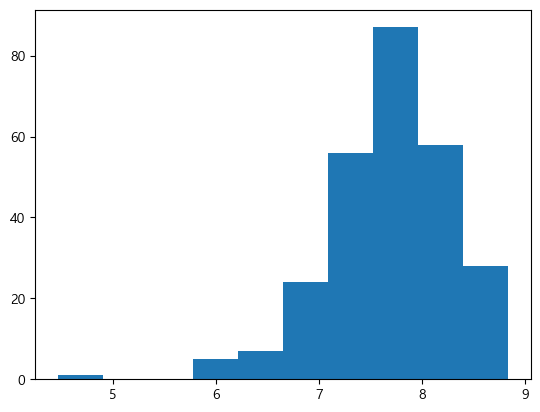

In [107]:
# total_rate 대한 histogram
plt.hist(df['s1_avg_rating'])
plt.show()

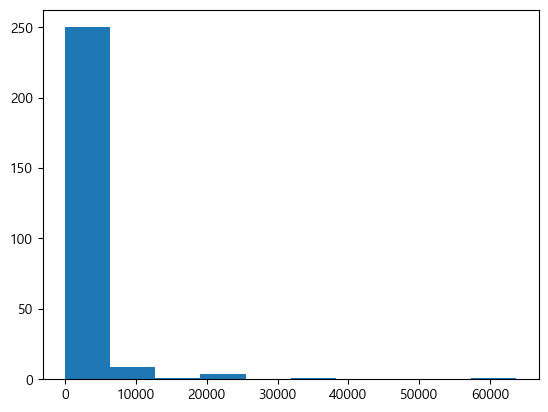

In [108]:
# total_rate 대한 histogram
plt.hist(df['s1_avg_views'])
plt.show()

In [109]:
df.sort_values(by='s1_avg_views',	   # 또는 바로 ['기준 컬럼']
			ascending=False)

,korean_title,english_title,runtime,age_rating,s1_avg_rating,s1_avg_views,s1_retention_rate,term,production_country_encoded
Unnamed: 0,,,,,,,,,
46,블랙 미러,Black Mirror,59,19,8.033333,63666.666667,103.174603,2,284.956487
17,브레이킹 배드,Breaking Bad,47,19,8.700000,33000.000000,68.181818,2,239.363693
24,기묘한 이야기,Stranger Things,61,15,8.787500,24125.000000,100.000000,0,239.363693
31,위쳐,The Witcher,57,19,8.275000,21000.000000,84.615385,0,239.363693
7,워킹 데드,The Walking Dead,46,19,8.533333,19500.000000,60.000000,2,239.363693
...,...,...,...,...,...,...,...,...,...
195,청춘시대,"Hello, My Twenties!",63,15,8.200000,18.416667,46.875000,2,288.718790
286,보좌관: 세상을 움직이는 사람들,Chief of Staff,66,15,8.600000,16.400000,66.666667,2,288.718790
152,미씽: 그들이 있었다,Missing: The Other Side,64,15,8.341667,15.833333,66.666667,2,288.718790


### 하위권은 확실히 우리나라 드라마 -> watcha랑 적절히 섞을것

---

# PCA

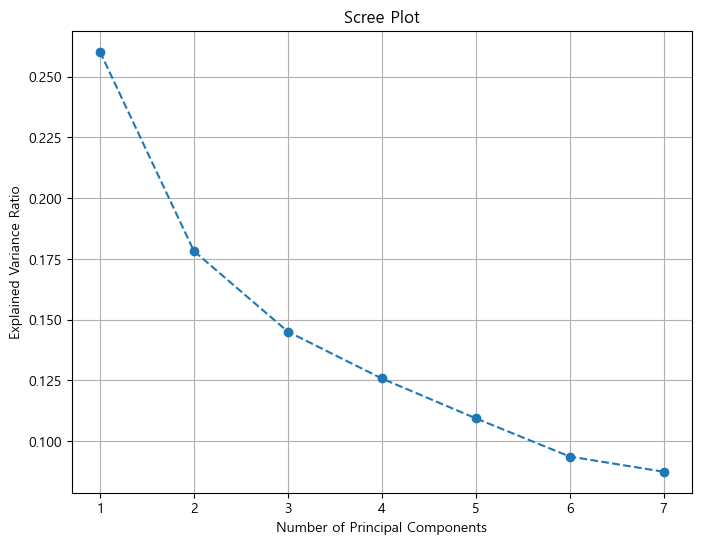

In [110]:
# PCA를 위한 데이터 준비
metrics_df = pd.DataFrame()

metrics_df['runtime'] = df['runtime']
metrics_df['age_rating'] = df['age_rating']
metrics_df['s1_avg_rating'] = df['s1_avg_rating']
metrics_df['s1_avg_views'] = df['s1_avg_views']
metrics_df['s1_retention_rate'] = df['s1_retention_rate']
metrics_df['term'] = df['term']
metrics_df['production_country_encoded'] = df['production_country_encoded']

# 데이터 표준화
scaler = StandardScaler()
metrics_df_scaled = scaler.fit_transform(metrics_df)

# PCA 수행
pca = PCA()
pca.fit(metrics_df_scaled)

# Scree Plot 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.grid(True)
plt.show()

In [111]:
# NumPy 배열을 데이터프레임으로 변환
metrics_df_scaled_df = pd.DataFrame(metrics_df_scaled, columns=metrics_df.columns)

In [112]:
# 설명된 분산 비율 출력
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio for each principal component:")
for i, var_ratio in enumerate(explained_variance_ratio, start=1):
    print(f"Principal Component {i}: {var_ratio:.4f}")

Explained variance ratio for each principal component:
Principal Component 1: 0.2602
Principal Component 2: 0.1783
Principal Component 3: 0.1451
Principal Component 4: 0.1258
Principal Component 5: 0.1094
Principal Component 6: 0.0937
Principal Component 7: 0.0875


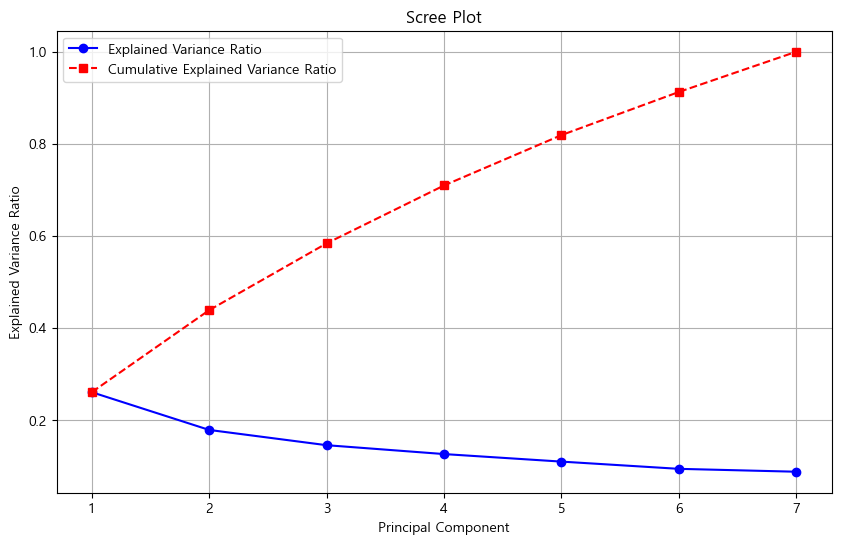

In [113]:
# 주성분 번호
components = range(1, len(explained_variance_ratio) + 1)

# 누적 설명된 분산 비율 계산
cumulative_variance_ratio = [sum(explained_variance_ratio[:i+1]) for i in range(len(explained_variance_ratio))]

# 팔꿈치 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(components, explained_variance_ratio, marker='o', linestyle='-', color='b', label='Explained Variance Ratio')
plt.plot(components, cumulative_variance_ratio, marker='s', linestyle='--', color='r', label='Cumulative Explained Variance Ratio')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(components)
plt.legend()
plt.grid(True)
plt.show()